Mean % error in u: 16.51%
Mean % error in v: 259.71%


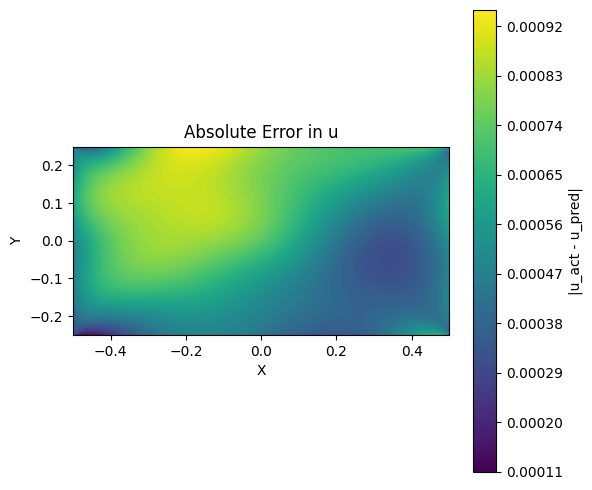

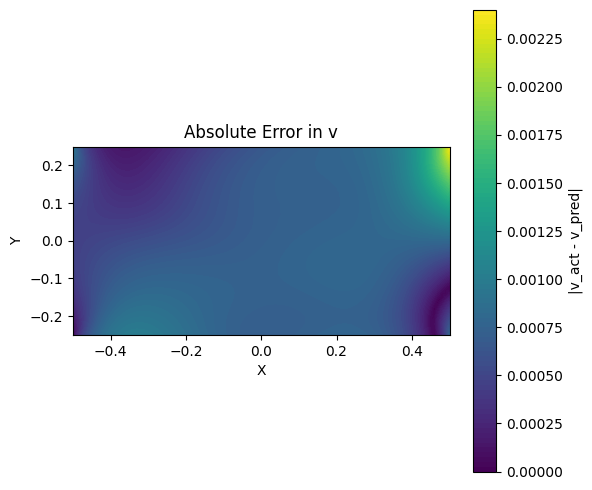

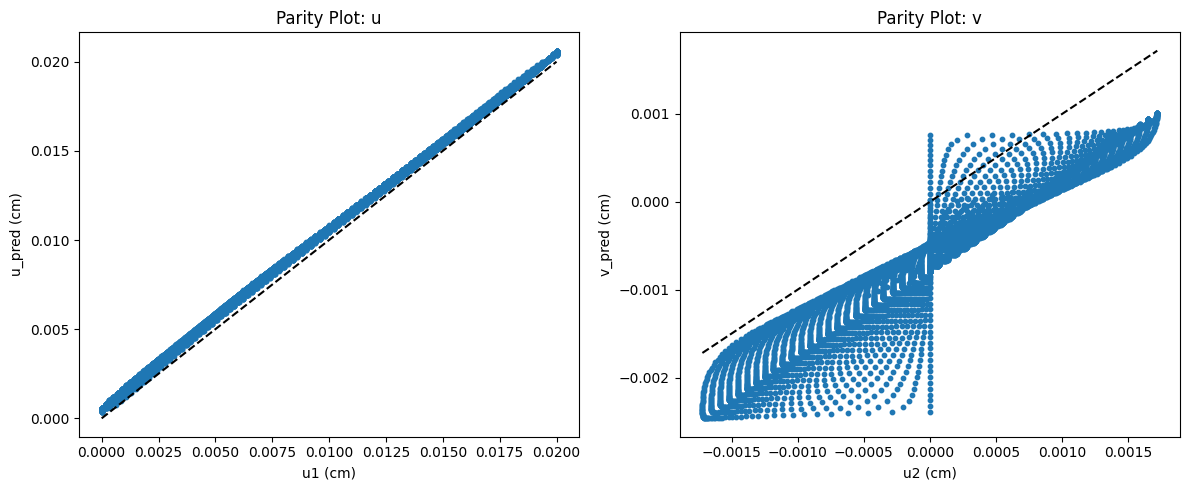

In [5]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# ─── 1) Define PINN Architecture ─────────────────────────────────────────────
L, W = 1.0, 0.5

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Softplus(beta=10),
            nn.Linear(128, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 6)
        )

    def forward(self, x, y):
        xi  = 2.0 * x / L
        eta = 2.0 * y / W
        return self.net(torch.cat([xi, eta], dim=1))

# ─── 2) Load Trained Weights ─────────────────────────────────────────────────
model = PINN()
state = torch.load("pinn_elasticity.pth", map_location="cpu", weights_only=True)
model.load_state_dict(state)
model.eval()

# ─── 3) Load and Clean COMSOL CSV ────────────────────────────────────────────
csv_path = '/Users/murat/Downloads/data.csv'  # keep filename unchanged
# Read CSV, skip lines starting with '%'
df = pd.read_csv(csv_path, comment='%')
# Clean column names: strip whitespace and leading '%'
df.columns = df.columns.str.strip().str.lstrip('%').str.strip()

# Columns should now be: X, Y, u1 (cm), u2 (cm), ...
X = df['X'].values
Y = df['Y'].values
u_act = df['u1 (cm)'].values  # actual u-displacement (cm)
v_act = df['u2 (cm)'].values  # actual v-displacement (cm)

# ─── 4) Prepare Input Tensors ───────────────────────────────────────────────
x_t = torch.tensor(X, dtype=torch.float32).reshape(-1,1)
y_t = torch.tensor(Y, dtype=torch.float32).reshape(-1,1)

# ─── 5) Forward Pass: Predict u, v ─────────────────────────────────────────
out = model(x_t, y_t)
# network outputs: [u_pred, v_pred, u_x, u_y, v_x, v_y]
u_pred = out[:,0].detach().numpy().flatten()
v_pred = out[:,1].detach().numpy().flatten()

df['u_pred'] = u_pred  # predicted u (cm)
df['v_pred'] = v_pred  # predicted v (cm)

# ─── 6) Compute Absolute & Percent Errors ───────────────────────────────────
df['err_u'] = np.abs(u_act - df['u_pred'])
df['err_v'] = np.abs(v_act - df['v_pred'])

df['pct_err_u'] = np.where(
    np.isclose(u_act, 0),
    0,
    df['err_u'] / np.abs(u_act) * 100
)
df['pct_err_v'] = np.where(
    np.isclose(v_act, 0),
    0,
    df['err_v'] / np.abs(v_act) * 100
)

# ─── 7) Display Percent Errors ───────────────────────────────────────────────
print(f"Mean % error in u: {df['pct_err_u'].mean():.2f}%")
print(f"Mean % error in v: {df['pct_err_v'].mean():.2f}%")

# ─── 8) Plotting Helpers ───────────────────────────────────────────────────
triang = mtri.Triangulation(X, Y)
def plot_contour(field, title, units=''):
    fig, ax = plt.subplots(figsize=(6,5))
    cf = ax.tricontourf(triang, field, levels=100, cmap='viridis')
    fig.colorbar(cf, ax=ax, label=units)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.set_aspect('equal', 'box')
    plt.tight_layout()
    plt.show()

# ─── 9) Visualize Absolute Errors ───────────────────────────────────────────
plot_contour(df['err_u'], 'Absolute Error in u', '|u_act - u_pred|')
plot_contour(df['err_v'], 'Absolute Error in v', '|v_act - v_pred|')

# ─── 10) Parity Plots ──────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].scatter(df['u1 (cm)'], df['u_pred'], s=10)
axes[0].plot([
    df['u1 (cm)'].min(), df['u1 (cm)'].max()
], [
    df['u1 (cm)'].min(), df['u1 (cm)'].max()
], 'k--')
axes[0].set_xlabel('u1 (cm)')
axes[0].set_ylabel('u_pred (cm)')
axes[0].set_title('Parity Plot: u')

axes[1].scatter(df['u2 (cm)'], df['v_pred'], s=10)
axes[1].plot([
    df['u2 (cm)'].min(), df['u2 (cm)'].max()
], [
    df['u2 (cm)'].min(), df['u2 (cm)'].max()
], 'k--')
axes[1].set_xlabel('u2 (cm)')
axes[1].set_ylabel('v_pred (cm)')
axes[1].set_title('Parity Plot: v')

plt.tight_layout()
plt.show()

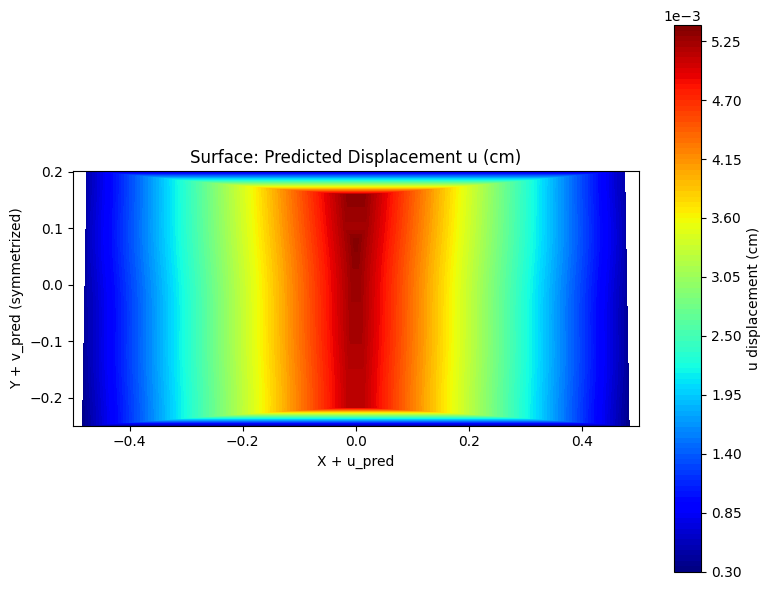

In [18]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# ─── Geometry and Model Parameters ──────────────────────────────────────────
L, W = 1.0, 0.5
deformation_scale = 50.0

# ─── Define PINN Model ──────────────────────────────────────────────────────
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Softplus(beta=10),
            nn.Linear(128, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 6)
        )

    def forward(self, x, y):
        xi  = 2.0 * x / L
        eta = 2.0 * y / W
        return self.net(torch.cat([xi, eta], dim=1))

# ─── Load Trained Model ─────────────────────────────────────────────────────
model = PINN()
state = torch.load("pinn_elasticity.pth", map_location="cpu", weights_only=True)
model.load_state_dict(state)
model.eval()

# ─── Load and Clean CSV ─────────────────────────────────────────────────────
df = pd.read_csv('/Users/murat/Downloads/data.csv', comment='%')
df.columns = df.columns.str.strip().str.lstrip('%').str.strip()
X = df['X'].values
Y = df['Y'].values

# ─── Predict with PINN ───────────────────────────────────────────────────────
x_t   = torch.tensor(X, dtype=torch.float32).view(-1,1)
y_t   = torch.tensor(Y, dtype=torch.float32).view(-1,1)
out   = model(x_t, y_t).detach().numpy()
u_pred = out[:, 0]
v_pred = out[:, 1]

# ─── Enforce Antisymmetry on v_pred about y = 0 ─────────────────────────────
v_sym = v_pred.copy()
for i, y in enumerate(Y):
    if y > 0:
        j = np.where(np.isclose(Y, -y, atol=1e-6))[0]
        if j.size == 1:
            avg      = 0.5*(v_pred[i] - v_pred[j[0]])
            v_sym[i] =  avg
            v_sym[j[0]] = -avg

# ─── Generate Deformed Coordinates ──────────────────────────────────────────
X_def = X + u_pred * deformation_scale
Y_def = Y + v_sym  * deformation_scale

# ─── Restrict to Left Half and Mirror ───────────────────────────────────────
mask    = (X_def >= -0.5) & (X_def <=  0.0)
X_left  = X_def[mask]
Y_left  = Y_def[mask]
u_left  = u_pred[mask]

# reflect across x = 0
X_right = -X_left
Y_right =  Y_left.copy()
u_right =  u_left.copy()

# combine halves
X_comb = np.concatenate([X_left,  X_right])
Y_comb = np.concatenate([Y_left,  Y_right])
u_comb = np.concatenate([u_left,  u_right])

# ─── Triangulate and Plot ───────────────────────────────────────────────────
tri = mtri.Triangulation(X_comb, Y_comb)

fig, ax = plt.subplots(figsize=(8,6))
tcf = ax.tricontourf(tri, u_comb, levels=100, cmap='jet')
cbar = fig.colorbar(tcf, ax=ax, label='u displacement (cm)')
cbar.ax.ticklabel_format(style='sci', scilimits=(0,0))

ax.set_title('Surface: Predicted Displacement u (cm)', fontsize=12)
ax.set_xlabel('X + u_pred')
ax.set_ylabel('Y + v_pred (symmetrized)')

# set x‐limits to full mirrored span
ax.set_xlim(-0.5, 0.5)

# set y‐limits exactly to your data (removes extra blue bands)
ax.set_ylim(Y_comb.min(), Y_comb.max())

ax.set_aspect('equal', 'box')
plt.tight_layout()
plt.show()
